# Strategic Clustering for Establishing a Restaurant in Mexico City
### By Dalia Y. Domíguez Jiménez

In [1]:
#Import the libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import json # library to handle JSON files
import numpy as np # library to handle data in a vectorized manner
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

## 1. Create the Data Frame of the Neighborhoods in Mexico City

We downloaded a Sample of the Mexican ZIP codes Latitude Longitud database from <a href="https://greatdata.com/product/mexican-postal-codes-database"></a> in order to get the neighborhoods (colonias) from Mexico City. 

The documentation and the file we will use are in the 'Mexican-Postal-With-Latitude-Longitude-Sample' Folder.

In [2]:
df = pd.read_csv('Mexican-Postal-With-Latitude-Longitude-Sample\mexl-demo-delim-utf8.csv')
df

Postal Code  Sequence No. State Code Type Code             Place Name  \
0           1000             1         DF       COL              San Angel   
1           1010             1         DF       COL              Los Alpes   
2           1020             1         DF       COL          Guadalupe Inn   
3           1030             1         DF       PBO                 Axotla   
4           1030             2         DF       COL                Florida   
..           ...           ...        ...       ...                    ...   
995        10840             1         DF        BO             Las Calles   
996        10840             2         DF        BO  Plazuela del Pedregal   
997        10900             1         DF       PBO  San Nicolás Totolapan   
998        10910             1         DF       PBO           La Magdalena   
999        10920             1         DF       COL            Las Huertas   

          Municipality Name Major City Name   Latitude  Longitude  
0            Álvaro Obregón          México  19.346257 -99.193169  
1            Álvaro Obregón          México  19.360502 -99.193958  
2            Álvaro Obregón          México  19.349653 -99.197087  
3            Álvaro Obregón          México  19.359138 -99.176073  
4            Álvaro Obregón          México  19.356070 -99.181523  
..                      ...             ...        ...        ...  
995  La Magdalena Contreras          México  19.304080 -99.232064  
996  La Magdalena Contreras          México  19.304080 -99.232064  
997  La Magdalena Contreras          México  19.297665 -99.242156  
998  La Magdalena Contreras          México  19.302101 -99.245791  
999  La Magdalena Contreras          México  19.298948 -99.240467  

[1000 rows x 9 columns]

Types of each column of the data frame:

In [3]:
df.dtypes

Postal Code            int64
Sequence No.           int64
State Code            object
Type Code             object
Place Name            object
Municipality Name     object
Major City Name       object
Latitude             float64
Longitude            float64
dtype: object

## 1.1 Clean the data 

### 1.1.1 Neighborhoods from CDMX (DF)

We want the neighborhoods from Mexico City or DF:

In [4]:
cdmx_df = df[df['State Code']=='DF']
cdmx_df

Postal Code  Sequence No. State Code Type Code             Place Name  \
0           1000             1         DF       COL              San Angel   
1           1010             1         DF       COL              Los Alpes   
2           1020             1         DF       COL          Guadalupe Inn   
3           1030             1         DF       PBO                 Axotla   
4           1030             2         DF       COL                Florida   
..           ...           ...        ...       ...                    ...   
995        10840             1         DF        BO             Las Calles   
996        10840             2         DF        BO  Plazuela del Pedregal   
997        10900             1         DF       PBO  San Nicolás Totolapan   
998        10910             1         DF       PBO           La Magdalena   
999        10920             1         DF       COL            Las Huertas   

          Municipality Name Major City Name   Latitude  Longitude  
0            Álvaro Obregón          México  19.346257 -99.193169  
1            Álvaro Obregón          México  19.360502 -99.193958  
2            Álvaro Obregón          México  19.349653 -99.197087  
3            Álvaro Obregón          México  19.359138 -99.176073  
4            Álvaro Obregón          México  19.356070 -99.181523  
..                      ...             ...        ...        ...  
995  La Magdalena Contreras          México  19.304080 -99.232064  
996  La Magdalena Contreras          México  19.304080 -99.232064  
997  La Magdalena Contreras          México  19.297665 -99.242156  
998  La Magdalena Contreras          México  19.302101 -99.245791  
999  La Magdalena Contreras          México  19.298948 -99.240467  

[1000 rows x 9 columns]

We are goint to check the Type Code out

In [5]:
cdmx_df.groupby('Type Code').count()

Postal Code  Sequence No.  State Code  Place Name  \
Type Code                                                      
BO                  55            55          55          55   
CAMP                 1             1           1           1   
COL                890           890         890         890   
EQUIP                2             2           2           2   
PBO                 52            52          52          52   

           Municipality Name  Major City Name  Latitude  Longitude  
Type Code                                                           
BO                        55               55        55         55  
CAMP                       1                1         1          1  
COL                      890              890       890        890  
EQUIP                      2                2         2          2  
PBO                       52               52        52         52

### 1.1.2 Type Code of the Neighborhoods

We are going to drop the CAMP and EQUIP from Type Code column.

In [6]:
cdmx_df = cdmx_df.drop(cdmx_df[cdmx_df['Type Code'] == 'CAMP'].index.tolist())
cdmx_df = cdmx_df.drop(cdmx_df[cdmx_df['Type Code'] == 'EQUIP'].index.tolist())
cdmx_df.groupby('Type Code').count()

Postal Code  Sequence No.  State Code  Place Name  \
Type Code                                                      
BO                  55            55          55          55   
COL                890           890         890         890   
PBO                 52            52          52          52   

           Municipality Name  Major City Name  Latitude  Longitude  
Type Code                                                           
BO                        55               55        55         55  
COL                      890              890       890        890  
PBO                       52               52        52         52

## 2. Explore the Place Names in Mexico City 

### 2.1 Municipality from Mexico City

Count the number of neigihborhood for each Municipality Name.

In [7]:
cdmx_df.groupby('Municipality Name').count()

Postal Code  Sequence No.  State Code  Type Code  \
Municipality Name                                                          
Azcapotzalco                     87            87          87         87   
Benito Juárez                    53            53          53         53   
Coyoacán                         95            95          95         95   
Cuajimalpa de Morelos            45            45          45         45   
Cuauhtémoc                       41            41          41         41   
Gustavo A. Madero               177           177         177        177   
Iztacalco                        38            38          38         38   
Iztapalapa                      199           199         199        199   
La Magdalena Contreras           40            40          40         40   
Álvaro Obregón                  222           222         222        222   

                        Place Name  Major City Name  Latitude  Longitude  
Municipality Name                                                         
Azcapotzalco                    87               87        87         87  
Benito Juárez                   53               53        53         53  
Coyoacán                        95               95        95         95  
Cuajimalpa de Morelos           45               45        45         45  
Cuauhtémoc                      41               41        41         41  
Gustavo A. Madero              177              177       177        177  
Iztacalco                       38               38        38         38  
Iztapalapa                     199              199       199        199  
La Magdalena Contreras          40               40        40         40  
Álvaro Obregón                 222              222       222        222

### 2.2 Build the map

In [8]:
address = 'Mexico City'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Mexico City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mexico City are 19.4326296, -99.1331785.


In [9]:
# create map of Toronto using latitude and longitude values
map_cdmx = folium.Map(location=[latitude, longitude], zoom_start=10)
colores = ['red', 'blue', 'green', 'purple', 'orange', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple','lightgreen']
munic = cdmx_df['Municipality Name'].unique().tolist()

# add markers to map
for lat, lng, placeName, MunName, typeCode in zip(cdmx_df['Latitude'], cdmx_df['Longitude'], cdmx_df['Place Name'], cdmx_df['Municipality Name'], cdmx_df['Type Code']):
    label = '{}, {}'.format(MunName, typeCode+'. '+placeName)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color = colores[munic.index(MunName)],   
        fill=True,
        fill_color=colores[munic.index(MunName)],
        fill_opacity=0.7,
        parse_html=False).add_to(map_cdmx)  
    
map_cdmx

#### There are 3 neighborhoods with a wrong location

In [10]:
cdmx_df[cdmx_df['Place Name'] == 'San Jerónimo Aculco'] #19.31904571840473, -99.22651633115254
cdmx_df[cdmx_df['Place Name'] == 'Lomas del Capulín'] #
cdmx_df[cdmx_df['Place Name'] == 'Ampliación Acueducto']

Postal Code  Sequence No. State Code Type Code            Place Name  \
26         1125             1         DF       COL  Ampliación Acueducto   

   Municipality Name Major City Name  Latitude  Longitude  
26    Álvaro Obregón          México  19.42116  -99.14536

In [11]:
cdmx_df = cdmx_df.drop(221)
cdmx_df = cdmx_df.drop(218)
cdmx_df = cdmx_df.drop(26)

#### Fuction to add legend from [link](https://stackoverflow.com/questions/65042654/how-to-add-categorical-legend-to-python-folium-map)

In [12]:
def add_categorical_legend(folium_map, title, colors, labels):
    if len(colors) != len(labels):
        raise ValueError("colors and labels must have the same length.")

    color_by_label = dict(zip(labels, colors))
    
    legend_categories = ""     
    for label, color in color_by_label.items():
        legend_categories += f"<li><span style='background:{color}'></span>{label}</li>"
        
    legend_html = f"""
    <div id='maplegend' class='maplegend'>
      <div class='legend-title'>{title}</div>
      <div class='legend-scale'>
        <ul class='legend-labels'>
        {legend_categories}
        </ul>
      </div>
    </div>
    """
    script = f"""
        <script type="text/javascript">
        var oneTimeExecution = (function() {{
                    var executed = false;
                    return function() {{
                        if (!executed) {{
                             var checkExist = setInterval(function() {{
                                       if ((document.getElementsByClassName('leaflet-top leaflet-right').length) || (!executed)) {{
                                          document.getElementsByClassName('leaflet-top leaflet-right')[0].style.display = "flex"
                                          document.getElementsByClassName('leaflet-top leaflet-right')[0].style.flexDirection = "column"
                                          document.getElementsByClassName('leaflet-top leaflet-right')[0].innerHTML += `{legend_html}`;
                                          clearInterval(checkExist);
                                          executed = true;
                                       }}
                                    }}, 100);
                        }}
                    }};
                }})();
        oneTimeExecution()
        </script>
      """
   

    css = """

    <style type='text/css'>
      .maplegend {
        z-index:9999;
        float:right;
        background-color: rgba(255, 255, 255, 1);
        border-radius: 5px;
        border: 2px solid #bbb;
        padding: 10px;
        font-size:12px;
        positon: relative;
      }
      .maplegend .legend-title {
        text-align: left;
        margin-bottom: 5px;
        font-weight: bold;
        font-size: 90%;
        }
      .maplegend .legend-scale ul {
        margin: 0;
        margin-bottom: 5px;
        padding: 0;
        float: left;
        list-style: none;
        }
      .maplegend .legend-scale ul li {
        font-size: 80%;
        list-style: none;
        margin-left: 0;
        line-height: 18px;
        margin-bottom: 2px;
        }
      .maplegend ul.legend-labels li span {
        display: block;
        float: left;
        height: 16px;
        width: 30px;
        margin-right: 5px;
        margin-left: 0;
        border: 0px solid #ccc;
        }
      .maplegend .legend-source {
        font-size: 80%;
        color: #777;
        clear: both;
        }
      .maplegend a {
        color: #777;
        }
    </style>
    """

    folium_map.get_root().header.add_child(folium.Element(script + css))

    return folium_map

In [13]:
map_cdmx = folium.Map(location=[latitude, longitude], zoom_start=10)
colores = ['red', 'blue', 'green', 'purple', 'orange', 'darkblue', 'darkgreen', 'cadetblue', 'pink','lightgreen']
munic = cdmx_df['Municipality Name'].unique().tolist()
# add markers to map
for lat, lng, placeName, MunName, typeCode in zip(cdmx_df['Latitude'], cdmx_df['Longitude'], cdmx_df['Place Name'], cdmx_df['Municipality Name'], cdmx_df['Type Code']):
    label = '{}, {}'.format(MunName, typeCode+'. '+placeName)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color = colores[munic.index(MunName)],   
        fill=True,
        fill_color=colores[munic.index(MunName)],
        fill_opacity=0.7,
        parse_html=False).add_to(map_cdmx)  
    
    
map_cdmx = add_categorical_legend(map_cdmx, 'Municipality',colors = colores,labels = munic)

map_cdmx.save("map.html")

map_cdmx

## Select certain municipalities

In [14]:
todelete = cdmx_df['Municipality Name'].unique()
cdmx_df = cdmx_df.drop(cdmx_df[cdmx_df['Municipality Name'] == todelete[1]].index.tolist())
cdmx_df = cdmx_df.drop(cdmx_df[cdmx_df['Municipality Name'] == todelete[4]].index.tolist())
cdmx_df = cdmx_df.drop(cdmx_df[cdmx_df['Municipality Name'] == todelete[6]].index.tolist())
cdmx_df = cdmx_df.drop(cdmx_df[cdmx_df['Municipality Name'] == todelete[-1]].index.tolist())
cdmx_df['Municipality Name'].unique()

array(['Álvaro Obregón', 'Benito Juárez', 'Coyoacán', 'Cuauhtémoc',
       'Iztacalco', 'Iztapalapa'], dtype=object)

In [15]:
map_cdmx = folium.Map(location=[latitude, longitude], zoom_start=10)
colores = ['red', 'blue', 'green', 'purple', 'orange', 'darkblue']# 'darkgreen', 'cadetblue', 'pink','lightgreen']
munic = cdmx_df['Municipality Name'].unique().tolist()
# add markers to map
for lat, lng, placeName, MunName, typeCode in zip(cdmx_df['Latitude'], cdmx_df['Longitude'], cdmx_df['Place Name'], cdmx_df['Municipality Name'], cdmx_df['Type Code']):
    label = '{}, {}'.format(MunName, typeCode+'. '+placeName)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color = colores[munic.index(MunName)],   
        fill=True,
        fill_color=colores[munic.index(MunName)],
        fill_opacity=0.7,
        parse_html=False).add_to(map_cdmx)  
    
    
map_cdmx = add_categorical_legend(map_cdmx, 'Municipality',colors = colores,labels = munic)

map_cdmx.save("map.html")

map_cdmx

#### How many neighborhoods each manucipality has?

In [16]:
neig_mun = pd.DataFrame({'Municipality Name':cdmx_df['Municipality Name'],'Number of Neighborhoods':cdmx_df['Place Name']})
neig_mun.groupby('Municipality Name').count()

Number of Neighborhoods
Municipality Name                         
Benito Juárez                           53
Coyoacán                                95
Cuauhtémoc                              41
Iztacalco                               38
Iztapalapa                             199
Álvaro Obregón                         219

### 2.3 Define Foursquare Credentials and Version

In [17]:
CLIENT_ID = 'OWPCBK4JBGUK1OEMAXO1MRZ43S3NNYVD4CYUA4J4BF4BMG0P' # your Foursquare ID
CLIENT_SECRET = 'SNK4WVH44RCCJLP201BLV4EKBW3WPOCIM2Y20XQ5M5WLUTP5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OWPCBK4JBGUK1OEMAXO1MRZ43S3NNYVD4CYUA4J4BF4BMG0P
CLIENT_SECRET:SNK4WVH44RCCJLP201BLV4EKBW3WPOCIM2Y20XQ5M5WLUTP5


### 2.4 Let's explore the first place in our dataframe

#### 2.4.1 Get the information of the place

Get the place's name

In [18]:
cdmx_df.loc[0,'Place Name']

'San Angel'

Get the neighborhood's latitude and longitude values.

In [19]:
place_lat = cdmx_df.loc[0,'Latitude']
place_lon = cdmx_df.loc[0,'Longitude']
place_name = cdmx_df.loc[0,'Place Name']

#### 2.4.2 Now, let's get the top 100 venues that are in San Angel within a radius of 500 meters.

First, let's create the GET request URL. Name your URL url.

In [20]:
# type your answer here
LIMIT = 100 
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    place_lat, 
    place_lon, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=OWPCBK4JBGUK1OEMAXO1MRZ43S3NNYVD4CYUA4J4BF4BMG0P&client_secret=SNK4WVH44RCCJLP201BLV4EKBW3WPOCIM2Y20XQ5M5WLUTP5&v=20180605&ll=19.346257,-99.193169&radius=500&limit=100'

Send the GET request and examine the results

In [21]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60ccc33d5f4b594e8f8a91ea'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Current map view',
  'headerFullLocation': 'Current map view',
  'headerLocationGranularity': 'unknown',
  'totalResults': 108,
  'suggestedBounds': {'ne': {'lat': 19.350757004500007,
    'lng': -99.18840859561305},
   'sw': {'lat': 19.341756995499995, 'lng': -99.19792940438694}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b0586fff964a5204f7a22e3',
       'name': 'Plaza San Jacinto',
       'location': {'address': 'Madero y Plaza San Jacinto',
        'lat': 19.34468435660432,
        'lng': -99.19210358696002,
        'labeledLatLngs': [{'label': 'display',
      

### 2.5 Fuction that extracts the category of the venue

Before we proceed, let's borrow the get_category_type function from the Foursquare lab.

In [22]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.

In [23]:
venues = results['response']['groups'][0]['items']
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

In [24]:
nearby_venues

venue.name        venue.categories  \
0                    Plaza San Jacinto                   Plaza   
1                     Saks San Jacinto      Mexican Restaurant   
2                            Bistró 83              Restaurant   
3                 Museo Casa Del Risco          History Museum   
4                     El Bazaar Sábado             Flea Market   
..                                 ...                     ...   
95                          El Tributo              Restaurant   
96                              Subway          Sandwich Place   
97                                Zara          Clothing Store   
98  Paseo escultórico José Luis Cuevas          Scenic Lookout   
99                           BoConcept  Furniture / Home Store   

    venue.location.lat  venue.location.lng  
0            19.344684          -99.192104  
1            19.344789          -99.192472  
2            19.346256          -99.191249  
3            19.345120          -99.192265  
4            19.344989          -99.192699  
..                 ...                 ...  
95           19.349600          -99.190929  
96           19.349222          -99.189726  
97           19.348960          -99.189577  
98           19.348469          -99.190735  
99           19.348825          -99.193561  

[100 rows x 4 columns]

And how many venues were returned by Foursquare?

In [25]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


### 2.6 Explore the places in Álvaro Obregón

#### 2.6.1 Let's create a function to repeat the same process to all the neighborhoods in Álvaro Obregón

In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### 2.6.2 Now write the code to run the above function on each neighborhood and create a new dataframe called _munic_venues_.

In [27]:
munic_df = cdmx_df[cdmx_df['Municipality Name'] == 'Álvaro Obregón']
munic_venues = getNearbyVenues(names=munic_df['Place Name'],
                                   latitudes=munic_df['Latitude'],
                                   longitudes=munic_df['Longitude'])

#### Let's check the size of the resulting dataframe

In [28]:
print(munic_venues.shape)
munic_venues

(3197, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0                 San Angel              19.346257              -99.193169   
1                 San Angel              19.346257              -99.193169   
2                 San Angel              19.346257              -99.193169   
3                 San Angel              19.346257              -99.193169   
4                 San Angel              19.346257              -99.193169   
...                     ...                    ...                     ...   
3192  Jardines del Pedregal              19.319742              -99.207419   
3193  Jardines del Pedregal              19.319742              -99.207419   
3194  Jardines del Pedregal              19.319742              -99.207419   
3195  Jardines del Pedregal              19.319742              -99.207419   
3196  Jardines del Pedregal              19.319742              -99.207419   

                     Venue  Venue Latitude  Venue Longitude  \
0        Plaza San Jacinto       19.344684       -99.192104   
1         Saks San Jacinto       19.344789       -99.192472   
2                Bistró 83       19.346256       -99.191249   
3     Museo Casa Del Risco       19.345120       -99.192265   
4         El Bazaar Sábado       19.344989       -99.192699   
...                    ...             ...              ...   
3192    BodyBrite Pedregal       19.318130       -99.211864   
3193               Jus Lab       19.319358       -99.211043   
3194              Teatique       19.319423       -99.210952   
3195     Superama Jardines       19.318155       -99.211022   
3196           Santa Clara       19.318142       -99.211510   

          Venue Category  
0                  Plaza  
1     Mexican Restaurant  
2             Restaurant  
3         History Museum  
4            Flea Market  
...                  ...  
3192                 Spa  
3193           Juice Bar  
3194            Tea Room  
3195         Supermarket  
3196      Ice Cream Shop  

[3197 rows x 7 columns]

Let's check how many venues were returned for each Neighborhood

In [29]:
munic_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                              
1a Ampliación Presidentes                            11   
1a Sección Cañada                                    12   
1a Victoria                                          28   
2a Ampliación Presidentes                            11   
2a Del Moral del Pueblo Tetelpan                      7   
...                                                 ...   
Torres de Potrero                                    14   
Villa Progresista                                    17   
Villa Solidaridad                                     5   
Villa Verdún                                          8   
Zenón Delgado                                        12   

                                  Neighborhood Longitude  Venue  \
Neighborhood                                                      
1a Ampliación Presidentes                             11     11   
1a Sección Cañada                                     12     12   
1a Victoria                                           28     28   
2a Ampliación Presidentes                             11     11   
2a Del Moral del Pueblo Tetelpan                       7      7   
...                                                  ...    ...   
Torres de Potrero                                     14     14   
Villa Progresista                                     17     17   
Villa Solidaridad                                      5      5   
Villa Verdún                                           8      8   
Zenón Delgado                                         12     12   

                                  Venue Latitude  Venue Longitude  \
Neighborhood                                                        
1a Ampliación Presidentes                     11               11   
1a Sección Cañada                             12               12   
1a Victoria                                   28               28   
2a Ampliación Presidentes                     11               11   
2a Del Moral del Pueblo Tetelpan               7                7   
...                                          ...              ...   
Torres de Potrero                             14               14   
Villa Progresista                             17               17   
Villa Solidaridad                              5                5   
Villa Verdún                                   8                8   
Zenón Delgado                                 12               12   

                                  Venue Category  
Neighborhood                                      
1a Ampliación Presidentes                     11  
1a Sección Cañada                             12  
1a Victoria                                   28  
2a Ampliación Presidentes                     11  
2a Del Moral del Pueblo Tetelpan               7  
...                                          ...  
Torres de Potrero                             14  
Villa Progresista                             17  
Villa Solidaridad                              5  
Villa Verdún                                   8  
Zenón Delgado                                 12  

[216 rows x 6 columns]

#### Let's find out how many unique categories can be curated from all the returned venues

In [30]:
print('There are {} uniques categories.'.format(len(munic_venues['Venue Category'].unique())))

There are 215 uniques categories.


In [31]:
venuesCat = munic_venues['Venue Category'].unique()
venuesCat

array(['Plaza', 'Mexican Restaurant', 'Restaurant', 'History Museum',
       'Flea Market', 'Dessert Shop', 'Gym', 'Optical Shop',
       'Coffee Shop', 'Boutique', 'Antique Shop', 'Bistro', 'Market',
       'Park', 'Falafel Restaurant', 'Health Food Store', 'Tea Room',
       'Breakfast Spot', 'Swiss Restaurant', 'Neighborhood',
       'Deli / Bodega', 'Furniture / Home Store', 'Japanese Restaurant',
       'French Restaurant', 'Shopping Mall',
       'Vegetarian / Vegan Restaurant', 'Candy Store', 'Art Gallery',
       'Café', 'Taco Place', 'BBQ Joint', 'Argentinian Restaurant',
       'Church', 'Ice Cream Shop', 'Brazilian Restaurant',
       'Massage Studio', 'Bookstore', 'Yoga Studio', 'Electronics Store',
       'Recreation Center', 'Museum', 'Italian Restaurant',
       'Comfort Food Restaurant', 'Spanish Restaurant', 'Public Art',
       'Bridal Shop', 'Bar', 'Mediterranean Restaurant', 'Karaoke Bar',
       'Food', 'Art Museum', 'Seafood Restaurant', 'Tapas Restaurant',
      

We're going to consider only the restaurant and venues related to food

In [32]:
for i in range(0,len(venuesCat)):
    if (venuesCat[i].find('Restaurant')==-1 and venuesCat[i].find('Food')==-1):
        munic_venues = munic_venues.drop(munic_venues[munic_venues['Venue Category'] == venuesCat[i]].index.tolist())

#### Take the restaurants from the data frame of the venues

In [33]:
 munic_venues

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
1                 San Angel              19.346257              -99.193169   
2                 San Angel              19.346257              -99.193169   
15                San Angel              19.346257              -99.193169   
16                San Angel              19.346257              -99.193169   
20                San Angel              19.346257              -99.193169   
...                     ...                    ...                     ...   
3153     Rincón de La Bolsa              19.331657              -99.252841   
3155     Rincón de La Bolsa              19.331657              -99.252841   
3164             Tlacoyaque              19.323871              -99.266564   
3180  Jardines del Pedregal              19.319742              -99.207419   
3186  Jardines del Pedregal              19.319742              -99.207419   

                          Venue  Venue Latitude  Venue Longitude  \
1              Saks San Jacinto       19.344789       -99.192472   
2                     Bistró 83       19.346256       -99.191249   
15          Jocoquería by Nifis       19.346510       -99.190570   
16                     Ecobutik       19.346130       -99.190713   
20                        KUH +       19.346164       -99.190765   
...                         ...             ...              ...   
3153      Ostioneria La Curvita       19.328736       -99.252135   
3155    Barbacoa Fam. Hernandez       19.328768       -99.254435   
3164     Tacos Miguel Santillan       19.327899       -99.266088   
3180  Sushi Roll Pedregal Jolie       19.319201       -99.211096   
3186                 Sushi Roll       19.319196       -99.211107   

          Venue Category  
1     Mexican Restaurant  
2             Restaurant  
15    Falafel Restaurant  
16     Health Food Store  
20      Swiss Restaurant  
...                  ...  
3153  Seafood Restaurant  
3155  Mexican Restaurant  
3164  Mexican Restaurant  
3180          Restaurant  
3186    Sushi Restaurant  

[794 rows x 7 columns]

Get the frequency of each Venue Category

In [34]:
count = munic_venues.groupby(['Venue Category']).count()['Venue'].tolist()
categories = sorted(munic_venues['Venue Category'].unique().tolist())
#freq = [x/sum(count) for x in count]
freq_df = pd.DataFrame({'Venue Category':categories, 'Number':count})
freq_df.sort_values(by=['Number'])

Venue Category  Number
30  Vegetarian / Vegan Restaurant       1
3              Belgian Restaurant       1
21      Middle Eastern Restaurant       1
29             Tex-Mex Restaurant       1
5            Caribbean Restaurant       2
19       Mediterranean Restaurant       2
8              Falafel Restaurant       2
16              Health Food Store       2
13                     Food Stand       2
28               Tapas Restaurant       3
27               Swiss Restaurant       3
22     Modern European Restaurant       3
0             American Restaurant       4
11              Food & Drink Shop       4
6              Chinese Restaurant       4
4            Brazilian Restaurant       5
15              French Restaurant       6
25             Spanish Restaurant       7
7         Comfort Food Restaurant      11
2                Asian Restaurant      12
18            Japanese Restaurant      13
1          Argentinian Restaurant      13
12                     Food Court      14
10                           Food      15
17             Italian Restaurant      16
9            Fast Food Restaurant      28
26               Sushi Restaurant      45
14                     Food Truck      67
23                     Restaurant      82
24             Seafood Restaurant      92
20             Mexican Restaurant     333

Get the top ten of the most frequent restaurants

In [36]:
topTen = freq_df.sort_values(by=['Number'],ascending=False)[:10]
topTen

Venue Category  Number
20    Mexican Restaurant     333
24    Seafood Restaurant      92
23            Restaurant      82
14            Food Truck      67
26      Sushi Restaurant      45
9   Fast Food Restaurant      28
17    Italian Restaurant      16
10                  Food      15
12            Food Court      14
18   Japanese Restaurant      13

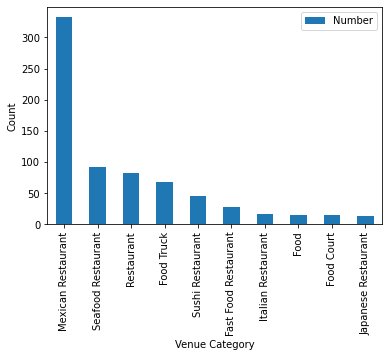

In [38]:
figAO=topTen.plot(x='Venue Category',y='Number',kind='bar',ylabel='Count')

# 3. Analyze each Municipality

### 3.1 Build the functions

Function to get the venues of each municipality and venues related to restaurants.

In [39]:
def restaurants_from(municipality):
    munic_df = cdmx_df[cdmx_df['Municipality Name'] == municipality] # get the neighborhoods of the municipality
    munic_venues = getNearbyVenues(names=munic_df['Place Name'],latitudes=munic_df['Latitude'],longitudes=munic_df['Longitude']) #get the venues
    venuesCat = munic_venues['Venue Category'].unique() # get the list with uniques venues 
    for i in range(0,len(venuesCat)): #of each venue 
        if (venuesCat[i].find('Restaurant')==-1 and venuesCat[i].find('Food')==-1): # if it's not related to food or restaurants
            munic_venues = munic_venues.drop(munic_venues[munic_venues['Venue Category'] == venuesCat[i]].index.tolist()) #drop it 
    return munic_venues

Function to get a dataframe with the most common restaurants from a municipality:

In [40]:
def mostCommonRestaurantsOf(dataframe,num=10):
    count = dataframe.groupby(['Venue Category']).count()['Venue'].tolist()
    categories = sorted(dataframe['Venue Category'].unique().tolist())
    freq_df = pd.DataFrame({'Venue Category':categories, 'Number':count})
    freq_df.sort_values(by=['Number'])
    topTen = freq_df.sort_values(by=['Number'],ascending=False)[:num]
    return topTen

### 3.2 Graph the top ten of each municipality

In [42]:
six_munc=cdmx_df['Municipality Name'].unique()
venuesBJ = restaurants_from(six_munc[1])
topTenBJ=mostCommonRestaurantsOf(venuesBJ,10)
venuesCy = restaurants_from(six_munc[2])
topTenCy=mostCommonRestaurantsOf(venuesCy,10)
venuesCt = restaurants_from(six_munc[3])
topTenCt=mostCommonRestaurantsOf(venuesCt,10)
venuesIo = restaurants_from(six_munc[4])
topTenIo=mostCommonRestaurantsOf(venuesIo,10)
venuesIa = restaurants_from(six_munc[5])
topTenIa=mostCommonRestaurantsOf(venuesIa,10)

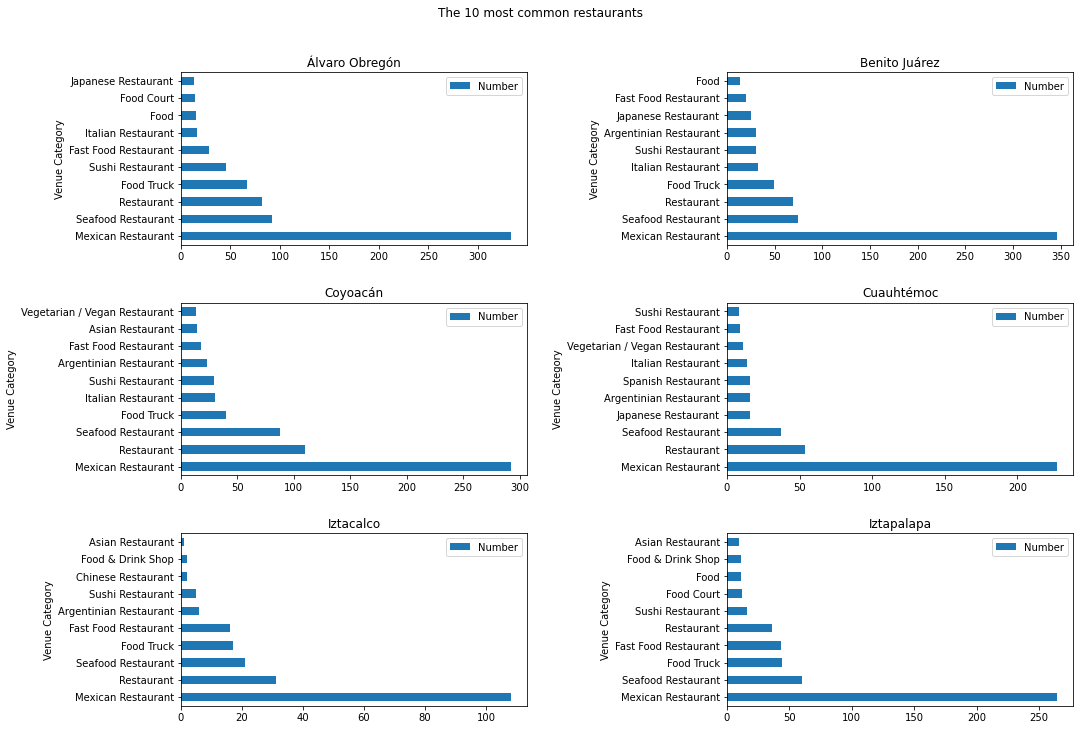

In [43]:
fig, ((ax1, ax2), (ax3,ax4), (ax5, ax6)) = plt.subplots(3,2)
fig.set_size_inches(15.5, 10.5)
fig.suptitle('The 10 most common restaurants')
topTen.plot(x='Venue Category',y='Number',kind='barh',ylabel='Number',title=six_munc[0],ax=ax1)
topTenBJ.plot(x='Venue Category',y='Number',kind='barh',ylabel='Number',title=six_munc[1],ax=ax2)
topTenCy.plot(x='Venue Category',y='Number',kind='barh',ylabel='Number',title=six_munc[2],ax=ax3)
topTenCt.plot(x='Venue Category',y='Number',kind='barh',ylabel='Number',title=six_munc[3],ax=ax4)
topTenIo.plot(x='Venue Category',y='Number',kind='barh',ylabel='Number',title=six_munc[4],ax=ax5)
topTenIa.plot(x='Venue Category',y='Number',kind='barh',ylabel='Number',title=six_munc[5],ax=ax6)
fig.tight_layout(pad=2.5)
plt.show()

Creat a data frame with the most common type of restaurants

In [44]:
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Municipality Name']
for ind in np.arange(10):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
mostCommon = pd.DataFrame(columns=columns)
mostCommon['Municipality Name'] = cdmx_df['Municipality Name'].unique()
mostCommon.iloc[0, 1:] = topTen['Venue Category'].tolist()
mostCommon.iloc[1, 1:] = topTenBJ['Venue Category'].tolist()
mostCommon.iloc[2, 1:] = topTenCy['Venue Category'].tolist()
mostCommon.iloc[3, 1:] = topTenCt['Venue Category'].tolist()
mostCommon.iloc[4, 1:] = topTenIo['Venue Category'].tolist()
mostCommon.iloc[5, 1:] = topTenIa['Venue Category'].tolist()
mostCommon

Municipality Name 1st Most Common Venue 2nd Most Common Venue  \
0    Álvaro Obregón    Mexican Restaurant    Seafood Restaurant   
1     Benito Juárez    Mexican Restaurant    Seafood Restaurant   
2          Coyoacán    Mexican Restaurant            Restaurant   
3        Cuauhtémoc    Mexican Restaurant            Restaurant   
4         Iztacalco    Mexican Restaurant            Restaurant   
5        Iztapalapa    Mexican Restaurant    Seafood Restaurant   

  3rd Most Common Venue 4th Most Common Venue   5th Most Common Venue  \
0            Restaurant            Food Truck        Sushi Restaurant   
1            Restaurant            Food Truck      Italian Restaurant   
2    Seafood Restaurant            Food Truck      Italian Restaurant   
3    Seafood Restaurant   Japanese Restaurant  Argentinian Restaurant   
4    Seafood Restaurant            Food Truck    Fast Food Restaurant   
5            Food Truck  Fast Food Restaurant              Restaurant   

    6th Most Common Venue   7th Most Common Venue  \
0    Fast Food Restaurant      Italian Restaurant   
1        Sushi Restaurant  Argentinian Restaurant   
2        Sushi Restaurant  Argentinian Restaurant   
3      Spanish Restaurant      Italian Restaurant   
4  Argentinian Restaurant        Sushi Restaurant   
5        Sushi Restaurant              Food Court   

           8th Most Common Venue 9th Most Common Venue  \
0                           Food            Food Court   
1            Japanese Restaurant  Fast Food Restaurant   
2           Fast Food Restaurant      Asian Restaurant   
3  Vegetarian / Vegan Restaurant  Fast Food Restaurant   
4             Chinese Restaurant     Food & Drink Shop   
5                           Food     Food & Drink Shop   

          10th Most Common Venue  
0            Japanese Restaurant  
1                           Food  
2  Vegetarian / Vegan Restaurant  
3               Sushi Restaurant  
4               Asian Restaurant  
5               Asian Restaurant

## 4. Analyze seafood restaurants in Iztacalco

In [45]:
seafoodRest=venuesIo[venuesIo['Venue Category']=='Seafood Restaurant']
seafoodRest

Neighborhood  Neighborhood Latitude  \
10   Gabriel Ramos Millán Sección Bramadero              19.393306   
22        Ex-Ejido de La Magdalena Mixiuhca              19.392971   
30        Ex-Ejido de La Magdalena Mixiuhca              19.392971   
37        Ex-Ejido de La Magdalena Mixiuhca              19.392971   
78    Gabriel Ramos Millán Sección Cuchilla              19.388369   
351                       Agrícola Oriental              19.395244   
362                       Agrícola Oriental              19.395244   
368                                El Rodeo              19.393436   
379                                El Rodeo              19.393436   
502                    Gabriel Ramos Millán              19.393048   
512                              INPI Picos              19.387556   
531       Los Picos de Iztacalco Sección 1b              19.387556   
550       Los Picos de Iztacalco Sección 2a              19.387556   
596                            Santiago Sur              19.387692   
621              Reforma Iztaccihuatl Norte              19.388570   
672                Reforma Iztaccihuatl Sur              19.377617   
689                     INFONAVIT Iztacalco              19.384116   
693                              Santa Cruz              19.388239   
702                              Santa Cruz              19.388239   
711                          Jardines Tecma              19.387616   
725                 Campamento 2 de Octubre              19.384722   

     Neighborhood Longitude                              Venue  \
10               -99.095007                   La Mojarra Feliz   
22               -99.088750                       Ponte Trucha   
30               -99.088750               El Camarón Guasaveño   
37               -99.088750                   La Mojarra Feliz   
78               -99.090954                   La Mojarra Feliz   
351              -99.070866               La trucha guapachosa   
362              -99.070866  Pescados Y Mariscos El Sinaloense   
368              -99.085336                       Ponte Trucha   
379              -99.085336               El Camarón Guasaveño   
502              -99.101378              Romulos Que Mariscos!   
512              -99.102854             Mariscos "El Bucanero"   
531              -99.102854             Mariscos "El Bucanero"   
550              -99.102854             Mariscos "El Bucanero"   
596              -99.125570                Mariscos "La Güera"   
621              -99.131289                      Aquí me quedo   
672              -99.128759                   Buzos Restaurant   
689              -99.106265             Mariscos "El Bucanero"   
693              -99.120426                   Marisco El Amigo   
702              -99.120426                Mariscos "La Güera"   
711              -99.116924                   Marisco El Amigo   
725              -99.116558                   Marisco El Amigo   

     Venue Latitude  Venue Longitude      Venue Category  
10        19.391178       -99.091578  Seafood Restaurant  
22        19.391782       -99.085788  Seafood Restaurant  
30        19.392220       -99.087940  Seafood Restaurant  
37        19.391178       -99.091578  Seafood Restaurant  
78        19.391178       -99.091578  Seafood Restaurant  
351       19.396586       -99.067987  Seafood Restaurant  
362       19.397181       -99.071980  Seafood Restaurant  
368       19.391782       -99.085788  Seafood Restaurant  
379       19.392220       -99.087940  Seafood Restaurant  
502       19.395687       -99.102725  Seafood Restaurant  
512       19.386949       -99.105109  Seafood Restaurant  
531       19.386949       -99.105109  Seafood Restaurant  
550       19.386949       -99.105109  Seafood Restaurant  
596       19.385943       -99.124196  Seafood Restaurant  
621       19.388624       -99.134506  Seafood Restaurant  
672       19.376795       -99.129880  Seafood Restaurant  
689       19.386949       -99.1051

In [46]:
neigh_seafood=seafoodRest['Neighborhood'].unique().tolist()

In [47]:
map_izta = folium.Map(location=[latitude, longitude], zoom_start=10)
from random import randint
colores = []
n = len(neigh_seafood)
for i in range(n):
    colores.append('#%06X' % randint(0, 0xFFFFFF))
    
# add markers to map
for lat, lng, placeName, neigh in zip(seafoodRest['Venue Latitude'], seafoodRest['Venue Longitude'], seafoodRest['Venue'], seafoodRest['Neighborhood']):
    label = '{}, {}'.format(neigh, placeName)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color = colores[neigh_seafood.index(neigh)],   
        fill=True,
        fill_color=colores[neigh_seafood.index(neigh)],
        fill_opacity=0.7,
        parse_html=False).add_to(map_izta)  
    
    
#map_izta = add_categorical_legend(map_izta, 'Municipality',colors = colores,labels = munic)

#map_izta.save("map.html")
map_izta

# 5. Cluster Neighborhoods

In [48]:
# one hot encoding
scarborough_onehot = pd.get_dummies(venuesIo[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
scarborough_onehot['Neighborhood'] = venuesIo['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [scarborough_onehot.columns[-1]] + list(scarborough_onehot.columns[:-1])
scarborough_onehot = scarborough_onehot[fixed_columns]

scarborough_onehot.head()

Neighborhood  Argentinian Restaurant  \
9   Gabriel Ramos Millán Sección Bramadero                       0   
10  Gabriel Ramos Millán Sección Bramadero                       0   
14  Gabriel Ramos Millán Sección Bramadero                       0   
15  Gabriel Ramos Millán Sección Bramadero                       0   
19  Gabriel Ramos Millán Sección Bramadero                       0   

    Asian Restaurant  Chinese Restaurant  Fast Food Restaurant  \
9                  0                   0                     1   
10                 0                   0                     0   
14                 0                   0                     0   
15                 0                   0                     0   
19                 0                   0                     1   

    Food & Drink Shop  Food Court  Food Stand  Food Truck  \
9                   0           0           0           0   
10                  0           0           0           0   
14                  0           0           0           1   
15                  0           0           0           0   
19                  0           0           0           0   

    Japanese Restaurant  Mexican Restaurant  Restaurant  Seafood Restaurant  \
9                     0                   0           0                   0   
10                    0                   0           0                   1   
14                    0                   0           0                   0   
15                    0                   1           0                   0   
19                    0                   0           0                   0   

    Sushi Restaurant  Yucatecan Restaurant  
9                  0                     0  
10                 0                     0  
14                 0                     0  
15                 0                     0  
19                 0                     0

In [49]:
scarborough_grouped = scarborough_onehot.groupby('Neighborhood').mean().reset_index()

In [50]:
# set number of clusters
kclusters = 5

scarborough_grouped_clustering = scarborough_grouped.drop('Neighborhood', 1)

# run k-means clustering
#kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(scarborough_grouped_clustering)

# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10] 

## 5.1 Evaluation

In [51]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=0)
    kmeanModel.fit(scarborough_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

In [52]:
[distortions[i-1]-distortions[i] for i in range(1,9)]

[3.1229134835757937,
 0.7189415233686058,
 0.642574142124515,
 0.29832462747003596,
 0.21200167504421907,
 0.24848250130665916,
 0.16176437973669144,
 0.18988936962908887]

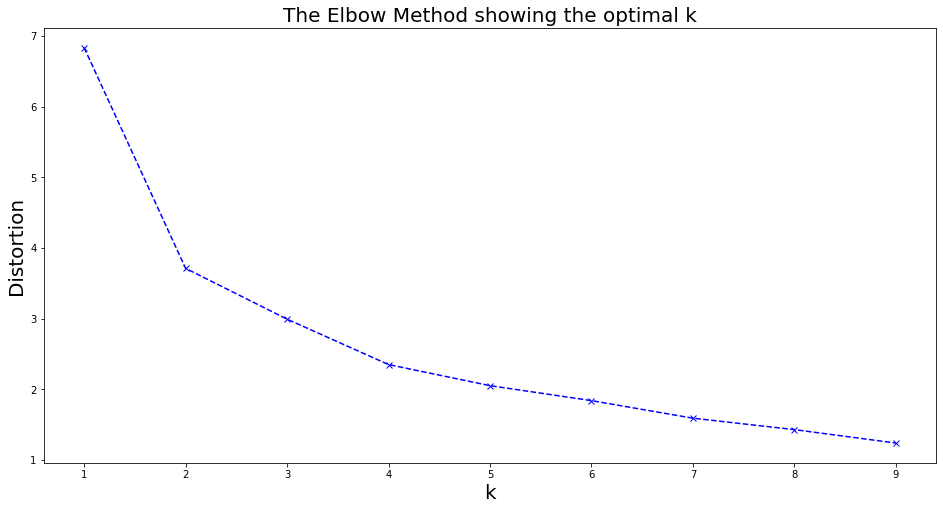

In [53]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx--')

plt.xlabel('k',fontsize=20)
plt.ylabel('Distortion',fontsize=20)
plt.title('The Elbow Method showing the optimal k',fontsize=20)
plt.show()

## 6. Results

### 6.1 Neighborhood in Iztacalco

In [54]:
# set number of clusters
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(scarborough_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 1, 1, 1, 0, 0, 1, 1])

### 6.2 Neighborhoods with their cluster

In [56]:
venuesIo.shape

(213, 7)

In [57]:
# add clustering labels
neig_izta=venuesIo.groupby('Neighborhood').first()
neig_izta.insert(0, 'Cluster Labels', kmeans.labels_)
neig_izta=neig_izta.reset_index()
neig_izta.head()

Neighborhood  Cluster Labels  Neighborhood Latitude  \
0                Agrícola Oriental               0              19.395244   
1               Agrícola Pantitlan               1              19.411247   
2  Ampliación Gabriel Ramos Millán               1              19.387802   
3          Campamento 2 de Octubre               1              19.384722   
4               Carlos Zapata Vela               1              19.382533   

   Neighborhood Longitude                   Venue  Venue Latitude  \
0              -99.070866        Tacos "El Guero"       19.396829   
1              -99.064762    La Mansion del Cuate       19.415138   
2              -99.095975              McDonald's       19.389844   
3              -99.116558        Marisco El Amigo       19.385495   
4              -99.097499  Gorditas de la Prepa 2       19.383463   

   Venue Longitude        Venue Category  
0       -99.069944    Mexican Restaurant  
1       -99.064475    Mexican Restaurant  
2       -99.099813  Fast Food Restaurant  
3       -99.117487    Seafood Restaurant  
4       -99.098236            Food Truck

In [106]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neig_izta['Neighborhood Latitude'], neig_izta['Neighborhood Longitude'], neig_izta['Neighborhood'], neig_izta['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters= add_categorical_legend(map_clusters, 'Clusters',colors = rainbow,labels = [1,0])

map_clusters.save("map_clusters.html")

map_clusters

### 6.3 Number of neighborhoods, venues and venues category for each cluster

In [59]:
neig_izta.groupby('Cluster Labels').count()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
Cluster Labels                                                                
0                         19                     19                      19   
1                         18                     18                      18   

                Venue  Venue Latitude  Venue Longitude  Venue Category  
Cluster Labels                                                          
0                  19              19               19              19  
1                  18              18               18              18

#### 6.3.1 Count the number of venues of each cluster

Cluster 0

In [60]:
neig_c0=neig_izta[neig_izta['Cluster Labels']==0]['Neighborhood'].tolist()
ven0 = []
for neig in neig_c0:
    ven0+=venuesIo[venuesIo['Neighborhood']==neig]['Venue'].tolist()
len(ven0)

130

Cluster 1

In [61]:
neig_c1=neig_izta[neig_izta['Cluster Labels']==1]['Neighborhood'].tolist()
ven1 = []
for neig in neig_c1:
    ven1+=venuesIo[venuesIo['Neighborhood']==neig]['Venue'].tolist()
len(ven1)

83

#### 6.3.2 Count the number of venues of each cluster

Cluster 1

In [62]:
venCat0 = []
for neig in neig_c0:
    venCat0+=(venuesIo[venuesIo['Neighborhood']==neig]['Venue Category'].unique().tolist())

Cluster 2

In [63]:
venCat1 = []
for neig in neig_c1:
    venCat1+=(venuesIo[venuesIo['Neighborhood']==neig]['Venue Category'].unique().tolist())

#### 6.3.3 Build the data frame

In [64]:
count_cluster = pd.DataFrame(columns=['Neighborhood','Cluster','Venue','Venue Category'])
count_cluster['Cluster'] = range(kclusters)
count_cluster = count_cluster.set_index('Cluster')
count_cluster['Neighborhood']=neig_izta.groupby('Cluster Labels').count()['Neighborhood'].tolist()
count_cluster['Venue'] = [len(ven0),len(ven1)]
count_cluster['Venue Category'] = [len(venCat0),len(venCat1)]
count_cluster

Neighborhood  Venue  Venue Category
Cluster                                     
0                  19    130              53
1                  18     83              65

<AxesSubplot:xlabel='Cluster', ylabel='Number'>

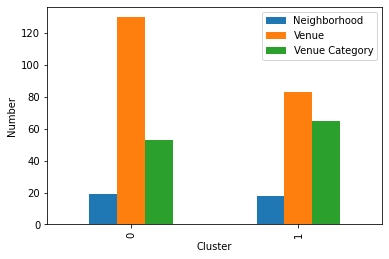

In [65]:
count_cluster.plot(kind='bar', ylabel='Number')

### 6.4 The 10 most common Venue Category of each cluster

#### 6.4.1 Cluster 0

In [66]:
count = []
venCat0_unique = [ ]
for venCat in list(dict.fromkeys(venCat0)):
    count.append(venCat0.count(venCat))
    venCat0_unique.append(venCat)
venCat0_df = pd.DataFrame({'Venue Category':venCat0_unique,'Number':count})
toptenC0 = venCat0_df.sort_values(by='Number', axis=0, ascending=False)[:10]
toptenC0

Venue Category  Number
0      Mexican Restaurant      19
3              Food Truck       7
1              Restaurant       6
2      Seafood Restaurant       6
5  Argentinian Restaurant       5
6    Fast Food Restaurant       3
7       Food & Drink Shop       2
4    Yucatecan Restaurant       1
8        Sushi Restaurant       1
9        Asian Restaurant       1

#### 6.4.1 Cluster 1

In [72]:
count = []
venCat1_unique = [ ]
for venCat in list(dict.fromkeys(venCat1)):
    count.append(venCat0.count(venCat))
    venCat1_unique.append(venCat)
venCat1_df = pd.DataFrame({'Venue Category':venCat1_unique,'Number':count})
toptenC1 = venCat1_df.sort_values(by='Number', axis=0, ascending=False)
toptenC1

Venue Category  Number
0    Mexican Restaurant      19
3            Food Truck       7
2            Restaurant       6
8    Seafood Restaurant       6
4  Fast Food Restaurant       3
6    Chinese Restaurant       1
7      Sushi Restaurant       1
1            Food Court       0
5            Food Stand       0

#### 6.4.2 Data Frame

In [73]:
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster']
for ind in np.arange(10):
    try:
        columns.append('{}{} Most Common Venue Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue Category'.format(ind+1))

# create a new dataframe
mostCommonC0 = pd.DataFrame(columns=columns)
mostCommonC0['Cluster'] = range(kclusters)
mostCommonC0.iloc[0, 1:] = toptenC0['Venue Category'].tolist()
mostCommonC0.iloc[1, 1:-1] = toptenC1['Venue Category'].tolist()

mostCommonC0

Cluster 1st Most Common Venue Category 2nd Most Common Venue Category  \
0        0             Mexican Restaurant                     Food Truck   
1        1             Mexican Restaurant                     Food Truck   

  3rd Most Common Venue Category 4th Most Common Venue Category  \
0                     Restaurant             Seafood Restaurant   
1                     Restaurant             Seafood Restaurant   

  5th Most Common Venue Category 6th Most Common Venue Category  \
0         Argentinian Restaurant           Fast Food Restaurant   
1           Fast Food Restaurant             Chinese Restaurant   

  7th Most Common Venue Category 8th Most Common Venue Category  \
0              Food & Drink Shop           Yucatecan Restaurant   
1               Sushi Restaurant                     Food Court   

  9th Most Common Venue Category 10th Most Common Venue Category  
0               Sushi Restaurant                Asian Restaurant  
1                     Food Stand                             NaN

### 6.5 The 10 most common Venue of each cluster

In [74]:
count = []
ven0_unique = [ ]
for ven in list(dict.fromkeys(ven0)):
    count.append(ven0.count(ven))
    ven0_unique.append(ven)
ven0_df = pd.DataFrame({'Venue':ven0_unique,'Number':count})
topten_venC0 = ven0_df.sort_values(by='Number', axis=0, ascending=False)[:10]
topten_venC0

Venue  Number
44               Birria El Cuñado       4
47        Birria Mi Lindo Jalisco       4
40                Birria El Paisa       4
45               Mi Lindo Jalisco       4
34  Tortas Del Recreo”El Vaquita”       4
39             Pozoleria La Troje       3
42                Tacos Don Pedro       3
46                    Burger King       3
21                  La esquiteria       3
43                     El Tarasco       2

In [75]:
count = []
ven1_unique = [ ]
for ven in list(dict.fromkeys(ven1)):
    count.append(ven1.count(ven))
    ven1_unique.append(ven)
ven1_df = pd.DataFrame({'Venue':ven1_unique,'Number':count})
topten_venC1 = ven1_df.sort_values(by='Number', axis=0, ascending=False)[:10]
topten_venC1

Venue  Number
4                               McDonald's       8
8                            Sushi Prepa 2       4
32                   Flautas "Salvatierra"       4
33                          Qks Doña Queta       4
34                  Mariscos "El Bucanero"       4
36                             El Bucanero       3
37  Restaurante El Palacio Centro Coyoacán       3
9                         Marisco El Amigo       3
18                      El Pollito NORTEÑO       2
38                     El sazón de la Vega       2

In [76]:
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster']
for ind in np.arange(10):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
mostCommonVenC0 = pd.DataFrame(columns=columns)
mostCommonVenC0['Cluster'] = range(kclusters)
mostCommonVenC0.iloc[0, 1:] = topten_venC0['Venue'].tolist()
mostCommonVenC0.iloc[1, 1:] = topten_venC1['Venue'].tolist()

mostCommonVenC0

Cluster 1st Most Common Venue    2nd Most Common Venue  \
0        0      Birria El Cuñado  Birria Mi Lindo Jalisco   
1        1            McDonald's            Sushi Prepa 2   

   3rd Most Common Venue 4th Most Common Venue          5th Most Common Venue  \
0        Birria El Paisa      Mi Lindo Jalisco  Tortas Del Recreo”El Vaquita”   
1  Flautas "Salvatierra"        Qks Doña Queta         Mariscos "El Bucanero"   

  6th Most Common Venue                   7th Most Common Venue  \
0    Pozoleria La Troje                         Tacos Don Pedro   
1           El Bucanero  Restaurante El Palacio Centro Coyoacán   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0           Burger King         La esquiteria             El Tarasco  
1      Marisco El Amigo    El Pollito NORTEÑO    El sazón de la Vega

### 6.6 Neighborhoods of each cluster

In [102]:
neig_clustered = pd.DataFrame(columns=['Cluster 0','Cluster 1'])
neig_clustered

Empty DataFrame
Columns: [Cluster 0, Cluster 1]
Index: []

In [87]:
neig0=neig_izta[neig_izta['Cluster Labels']==0]['Neighborhood'].tolist()
neig1=neig_izta[neig_izta['Cluster Labels']==1]['Neighborhood'].tolist()

In [104]:
if len(neig0)>len(neig1):
    neig_clustered['Cluster 0'] = neig0
    neig_clustered['Cluster 1'][:len(neig1)] = neig1
else:
    neig_clustered['Cluster 1'] = neig1
    neig_clustered['Cluster 0'][:len(neig0)] = neig0
neig_clustered

Cluster 0  \
0                       Agrícola Oriental   
1                                El Rodeo   
2       Ex-Ejido de La Magdalena Mixiuhca   
3   Gabriel Ramos Millán Sección Cuchilla   
4   Gabriel Ramos Millán Sección Tlacotal   
5                          Granjas México   
6                         Juventino Rosas   
7       Los Picos de Iztacalco Sección 1a   
8                               Los Reyes   
9                           Militar Marte   
10                      Nueva Santa Anita   
11             Reforma Iztaccihuatl Norte   
12               San Francisco Xicaltongo   
13                             San Miguel   
14                            Santa Anita   
15                           Santiago Sur   
16                              Tlazintla   
17                        Viaducto Piedad   
18                                Zapotla   

                                 Cluster 1  
0                       Agrícola Pantitlan  
1          Ampliación Gabriel Ramos Millán  
2                  Campamento 2 de Octubre  
3                       Carlos Zapata Vela  
4               Cuchilla Agrícola Oriental  
5                   Fraccionamiento Coyuya  
6                     Gabriel Ramos Millán  
7   Gabriel Ramos Millán Sección Bramadero  
8                      INFONAVIT Iztacalco  
9                               INPI Picos  
10                          Jardines Tecma  
11                                 La Cruz  
12       Los Picos de Iztacalco Sección 1b  
13       Los Picos de Iztacalco Sección 2a  
14                Reforma Iztaccihuatl Sur  
15                               San Pedro  
16                              Santa Cruz  
17                          Santiago Norte  
18                                     NaN

### 6.7 Sea food restaurants

In [145]:
seafood =venuesIo[venuesIo['Venue Category']=='Seafood Restaurant']
seafood.head()

Neighborhood  Neighborhood Latitude  \
10  Gabriel Ramos Millán Sección Bramadero              19.393306   
22       Ex-Ejido de La Magdalena Mixiuhca              19.392971   
30       Ex-Ejido de La Magdalena Mixiuhca              19.392971   
37       Ex-Ejido de La Magdalena Mixiuhca              19.392971   
78   Gabriel Ramos Millán Sección Cuchilla              19.388369   

    Neighborhood Longitude                 Venue  Venue Latitude  \
10              -99.095007      La Mojarra Feliz       19.391178   
22              -99.088750          Ponte Trucha       19.391782   
30              -99.088750  El Camarón Guasaveño       19.392220   
37              -99.088750      La Mojarra Feliz       19.391178   
78              -99.090954      La Mojarra Feliz       19.391178   

    Venue Longitude      Venue Category  
10       -99.091578  Seafood Restaurant  
22       -99.085788  Seafood Restaurant  
30       -99.087940  Seafood Restaurant  
37       -99.091578  Seafood Restaurant  
78       -99.091578  Seafood Restaurant

In [152]:
map_seafood= folium.Map(location=[latitude, longitude], zoom_start=11)


# add markers to the map
for lat, lon, poi, ven in zip(seafood['Neighborhood Latitude'], seafood['Neighborhood Longitude'], seafood['Neighborhood'],seafood['Venue']):
    try:
        neig0.index(poi)
        col = 'red'
    except ValueError:
        col = 'purple'
    label = folium.Popup(ven+', '+poi, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=col,
        fill=True,
        fill_color=col,
        fill_opacity=0.7).add_to(map_seafood)

map_seafood= add_categorical_legend(map_seafood, 'Clusters',colors = ['purple','red'],labels = [1,0])

map_seafood.save("map_clusters.html")

map_seafood